In [1]:
import os
import numpy as np 
import pandas as pd
import arcpy
from arcpy import env

In [2]:
result_path = r"F:\cache_data\pre_soiltype_table\dy\autogluon\predict_csv\prediction_ph_RandomForestEntr.csv"

In [3]:
# 读取预测结果
data = pd.read_csv(result_path,index_col=False)

In [4]:
stander_path = r"D:\ArcGISProjects\workspace\shbyq\features_data_dy.gdb\DEM"

In [5]:
data.columns

Index(['prediction_0', 'prediction_1', 'prediction_2', 'prediction_3',
       'prediction_4', 'prediction_5', 'prediction_6', 'prediction_7',
       'prediction_8', 'prediction_9',
       ...
       'prediction_334', 'prediction_335', 'prediction_336', 'prediction_337',
       'prediction_338', 'prediction_339', 'prediction_340', 'prediction_341',
       'prediction_342', 'prediction_343'],
      dtype='object', length=344)

In [6]:
# 合并除第一列外的所有列到第一列
frames = []
for col in data.columns:
    frames.append(data[col])

# 合并 DataFrame
merged_data = pd.concat(frames, axis=0, ignore_index=True)

In [7]:
merged_data.dropna(inplace=True)

In [8]:
merged_data.size

171871183

In [9]:
merged_data.value_counts()

25.0    48293400
34.0    31983230
38.0    22201791
40.0    10843666
24.0    10754929
          ...   
81.0       10856
64.0        8788
94.0        8538
13.0        4332
4.0         2106
Length: 73, dtype: int64

In [20]:

def label_array(mixed_array):
    # 获取唯一的值
    unique_values = list(set(merged_data.values))

    # 创建一个字典来映射唯一值到标签
    label_mapping = {value: index for index, value in enumerate(unique_values)}

    # 使用字典映射函数将数组标签化
    labeled_array = np.vectorize(label_mapping.get)(mixed_array)
    return labeled_array,label_mapping

In [21]:
# 标签化array
cach_result = label_array(merged_data)

In [22]:
type(merged_data)

pandas.core.series.Series

In [10]:
dem_array = arcpy.RasterToNumPyArray(stander_path)
dem_array.shape

(12881, 13343)

In [11]:
dem_array.shape[0] * dem_array.shape[1]

171871183

In [12]:
raster_array = np.reshape(merged_data.values,dem_array.shape)

In [13]:
raster_array = raster_array.astype(np.float32)

In [14]:
dem_array.dtype,raster_array.dtype

(dtype('float32'), dtype('float32'))

In [15]:
env.workspace = r"D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result.gdb"
env.extent = stander_path

In [16]:
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster

In [17]:
# 按掩膜处理
result_raster = mask_raster(raster_array,stander_path, 5)
result_raster.save("prediction_sioltype_autorfe")
print("完成")

完成


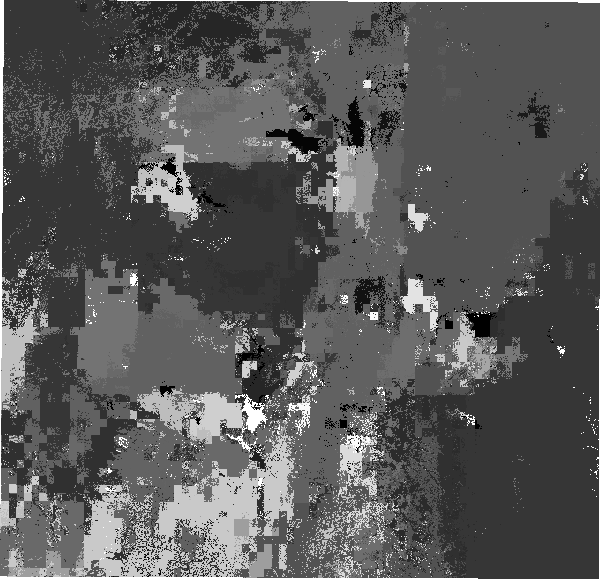

In [18]:
result_raster